In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import time

from xgboost import XGBRegressor

from joblib import dump
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import plot_tree

In [2]:
plt.style.use('ggplot')

# 10-xg-boost

In [3]:
X_train = pd.read_csv('../data/processed/train_features.csv')
y_train = pd.read_csv('../data/processed/train_target.csv')

In [4]:
X_test = pd.read_csv('../data/processed/test_features.csv')
y_test = pd.read_csv('../data/processed/test_target.csv')

In [5]:
X_train = X_train.select_dtypes('number')
X_test = X_test.select_dtypes('number')

In [6]:
cols = X_train.columns.tolist()

In [7]:
assert list(X_train.columns) == list(X_test.columns)

In [8]:
X_cols, y_cols = X_train.columns, y_train.columns

In [9]:
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

In [10]:
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

In [11]:
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

In [12]:
X_train = pd.DataFrame(X_train, columns=X_cols)
X_test = pd.DataFrame(X_test, columns=X_cols)

In [13]:
y_train = pd.DataFrame(y_train, columns=y_cols)
y_test = pd.DataFrame(y_test, columns=y_cols)

In [14]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

## XGBoost

In [15]:
# param_grid = {
#     'n_estimators': [50, 100, 150, 200],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.1, 1]
# }

In [16]:
param_grid = {
    'n_estimators': [200],
    'max_depth': [3],
    'learning_rate': [1]
}

In [17]:
mdl = XGBRegressor(random_state=42)

In [18]:
t1 = time.time()
gscv = GridSearchCV(mdl, n_jobs=-1, cv=cv, param_grid=param_grid, verbose=1)
gscv.fit(X_train, y_train)
t2 = time.time()
print(t2 - t1)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
350.19582772254944


In [19]:
mdl = gscv.best_estimator_
mdl

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=1, max_delta_step=0, max_depth=3, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200,
             n_jobs=14, num_parallel_tree=1, random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [20]:
dump(mdl, '../models/xgb_regressor.joblib')

['../models/xgb_regressor.joblib']

In [21]:
mean_squared_error(
    target_scaler.inverse_transform(y_train),
    target_scaler.inverse_transform(mdl.predict(X_train).reshape(-1,1)),
    squared=False
)

4824.361914486041

In [22]:
mean_squared_error(
    target_scaler.inverse_transform(y_test),
    target_scaler.inverse_transform(mdl.predict(X_test).reshape(-1,1)),
    squared=False
)

5042.695496260533

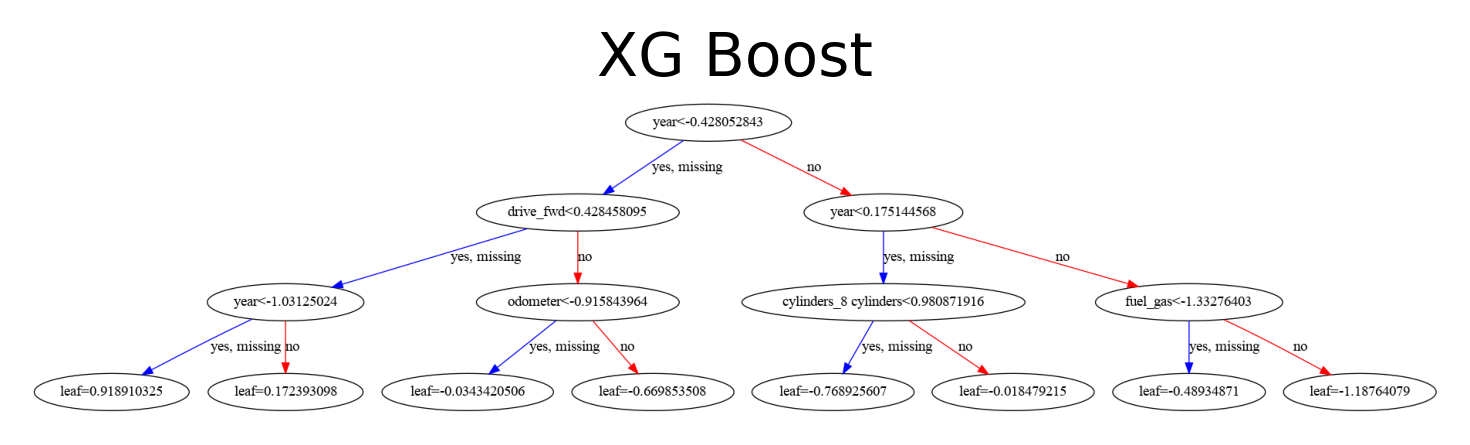

In [28]:
plt.figure(figsize=(5,5), dpi=300)
ax = plt.gca()
plot_tree(mdl, ax=ax)
plt.title('XG Boost')
plt.tight_layout()
plt.savefig(f'../reports/figures/xgb_tree.png')